# Chapter 4: heating

## Setup

In [1]:
using Ogre
using WaterData
using DataFrames
using DataFramesMeta
using Plots
using ThesisUtils
using LaTeXStrings
using ProgressMeter
using BasicUnits
    bar = BasicUnits.bar;

In [86]:
# Function to save figure data to a JLD file in the figdata directory
using JLD
datadir = "figdata/generated/"

"Save a dictionary of values into a JLD file"
function savefigdata(id, datadict)
    filename = joinpath(datadir, id) * ".jld"
    save(filename, datadict)
end

"Load a dictionary of values from a JLD file"
function loadfigdata(id)
    filename = joinpath(datadir, id) * ".jld"
    load(filename)
end

# Common plotting options
xaxis=(L"Mass $M$ / M$_⊕$", (0.5, 10))
yaxis=(L"Radius $R$ / R$_⊕$", (0, 3))

# Write a number like 10000 as 10^5 in LaTeX
function latex_power(x)
    x == 0 && return L"0"
    logx = round(Int, log10(x))
    latexstring("10^{$logx}")
end

# Add a unit to the nth (default 1st) item in a list of latex strings
function addunit!(labels, unit, n=1)
    l = labels[n]
    labels[n] = latexstring("$l\$\\,\$$unit")
end 

# Add a symbol (e.g. "κ = ") to the nth (default 1st) item in a list of latex strings
function addsym!(labels, symbol, n=1)
    l = labels[n]
    labels[n] = latexstring("\$$symbol = \$$l")
end

# Convert parameter values into a title string
function parvalues(str, d)
    fwater = 100 - round(Int, d["f0"] * 100)
    Tirr0  = d["Tirr0"]
    M0 = d["M0"]
    κ0 = d["κ0"]
    γ0 = d["γ0"]
    ɛ0 = d["ɛ0"]
    Psurf0 = d["Psurf0"]
    replacements = Dict(
        "M0" => string(M0/M_earth) * L"$\,$M$_⊕$",
        "f0" => string(fwater) * "% water",
        "Tirr0" => string(Tirr0) * L"$\,$K",
        "κ0" => string(κ0) * L"$\,$m$^2$/kg",
        "γ0" => string(γ0),
        "ɛ0" => latex_power(ɛ0) * L"$\,$W/kg",
        "Psurf0" => string(Psurf0 / 1e5) * L"$\,$bar"
    )

    
    if d["κ0"] == nothing
        replacements["κ0"] = "variable"
    end
    
    for (s, r) in replacements
        str = replace(str, s, r, 1)
    end
    
    return str
end;

## Data generation

In [5]:
# Parameter exploration values
const Ms_ME = linspace(0.5, 10, 30)
const Ms = Ms_ME * M_earth
const ɛ0 = 1e-12 * W/kg
const Tirr0 = 300 * K
const fcore0 = 0.7
const firon = fcore0 * 1/3
const fsilicate = fcore0 * 2/3
const κ0 = nothing
const γ0 = 0.01
const M0 = 5M_earth
const Psurf0 = 100bar

shared_data = Dict(
    "Ms" => Ms,
    "f0" => fcore0,
    "Tirr0" => Tirr0,
    "M0" => M0,
    "κ0" => κ0,
    "γ0" => γ0,
    "ɛ0" => ɛ0,
    "Psurf0" => Psurf0);

In [18]:
function internal_heat()
    ɛs = [0, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10] * W/kg |> reverse

    # As internal temp -> 0, atmosphere disappears
    N = length(ɛs) * length(Ms)
    p = Progress(N)
    Rs = map(ɛs) do ɛ
        map(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, firon, fsilicate, ɛ, Tirr0, κ0, γ0, Psurf0)
            return r
        end
    end
    
    data = Dict(
        shared_data...,
        "ɛs" => ɛs,
        "Rs" => Rs
    )
    
    savefigdata("internal-heat", data)
end

internal_heat()

Progress:   1%|                                         |  ETA: 0:08:49

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


In [24]:
function internal_heat_profiles()
    κs = [nothing, 0, 100]
    ɛs = [0, 1e-14, 1e-12, 1e-10] * W/kg |> reverse
    
    N = length(ɛs) * length(κs)
    p = Progress(N)
    
    data = Dict()
    
    for κ in κs
        Ps = Vector{Float64}[]
        Ts = Vector{Float64}[]
        foreach(ɛs) do ɛ
            next!(p)
            s, r = Ogre.interior(M0, firon, fsilicate, ɛ, Tirr0, κ, γ0, Psurf0)
            P = Ogre.pressure(s)
            T = Ogre.temperature(s)
            Patm = P[P .< 10000bar]
            Tatm = T[P .< 10000bar]
            @assert length(Patm) == length(Tatm)
            push!(Ps, Patm)
            push!(Ts, Tatm)
        end
    
        data[string(κ)] = Dict(
            shared_data...,
            "ɛs" => ɛs,
            "Ps" => Ps,
            "κ0" => κ,
            "Ts" => Ts
        )
    end  
    
    savefigdata("internal-heat-profiles", data)
end
        
internal_heat_profiles()  

Progress:  25%|██████████                               |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [19]:
function irradiation()
    Tirrs = [300, 600, 1000] * K

    # As external temp -> 0, atmosphere disappears
    N = length(Tirrs) * length(Ms)
    p = Progress(N)
    reverse!(Tirrs)
    Rs = map(Tirrs) do Tirr
        map(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr, κ0, γ0, Psurf0)
            return r
        end
    end
    
    data = Dict(
        shared_data...,
        "Tirrs" => Tirrs,
        "Rs" => Rs,
    )
    
    savefigdata("irradiation", data)
end

irradiation()

Progress:   4%|██                                       |  ETA: 0:00:13

INFO: Incomplete centre convergence (-3.0494301477075377e6 m)


Progress:  31%|█████████████                            |  ETA: 0:00:11

INFO: Incomplete centre convergence (-386041.267480618 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [25]:
function irradiation_profiles()
    κs = [nothing, 0, 100]
    Tirrs = [300, 600, 1000] * K |> reverse
    
    N = length(Tirrs) * length(κs)
    p = Progress(N)
    
    data = Dict()
    
    for κ in κs
        Ps = Vector{Float64}[]
        Ts = Vector{Float64}[]
        foreach(Tirrs) do Tirr
            next!(p)
            s, r = Ogre.interior(M0, firon, fsilicate, ɛ0, Tirr, κ, γ0, Psurf0)
            P = Ogre.pressure(s)
            T = Ogre.temperature(s)
            Patm = P[P .< 100bar]
            Tatm = T[P .< 100bar]
            @assert length(Patm) == length(Tatm)
            push!(Ps, Patm)
            push!(Ts, Tatm)
        end

        data[string(κ)] = Dict(
            shared_data...,
            "Tirrs" => Tirrs,
            "κ0" => κ,
            "Ps" => Ps,
            "Ts" => Ts
        )
    end
    
    savefigdata("irradiation-profiles", data)
end   

irradiation_profiles()

Progress:  33%|██████████████                           |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [45]:
function core_fraction()
    fs_percent = [30, 50, 70, 90, 97]
    fs = fs_percent / 100
    wfrac_percent = 100 .- fs_percent

    N = (length(fs)+1) * length(Ms)

    # As core fraction -> 1, atmosphere disappears
    p = Progress(N)
    Rs = map(fs) do f
        map(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, f/3, 2f/3, ɛ0, Tirr0, κ0, γ0, Psurf0)
            return r
        end
    end
    Rs_rock = map(Ms) do M
        next!(p)
        s, r = Ogre.interior(M, 1/3, 2/3, ɛ0, Tirr0, κ0, γ0, Psurf0)
        return r
    end
    
    data = Dict(
        shared_data...,
        "fs" => fs,
        "Rs" => Rs,
        "Rs_rock" => Rs_rock
    )
    
    savefigdata("core-fraction", data)
end

core_fraction()

Progress:   2%|█                                        |  ETA: 0:00:27

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


In [47]:
function opacities()
    κs = Any[0, 1, 10, 100, 1000]

    # As opacity -> 0, atmosphere becomes isothermal
    N = (length(κs)) * length(Ms)
    p = Progress(N)
    reverse!(κs)
    Rs = map(κs) do κ
        map(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, κ, γ0, Psurf0)
            return r
        end
    end
    Rs_freeκ = map(Ms) do M
        next!(p)
        s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, nothing, γ0, Psurf0)
        return r
    end
    
    data = Dict(
        shared_data...,
        "κs" => κs,
        "Rs" => Rs,
        "Rs_freeκ" => Rs_freeκ
    )
    
    savefigdata("opacities", data)
end

opacities()

Progress:  63%|██████████████████████████               |  ETA: 0:00:10

INFO: Incomplete centre convergence (-354811.0356003392 m)


Progress:  67%|████████████████████████████             |  ETA: 0:00:09

INFO: Incomplete centre convergence (512685.8328169525 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


In [49]:
function opacity_ratio()
    γs = Any[1e-2, 1e-1, 1, 10]

    # As opacity -> 0, atmosphere becomes isothermal
    N = (length(γs)) * length(Ms)
    p = Progress(N)
    Rs = map(γs) do γ
        map(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, κ0, float(γ), Psurf0)
            return r
        end
    end
    
    data = Dict(
        shared_data...,
        "γs" => γs,
        "Rs" => Rs
    )
    
    savefigdata("opacity-ratios", data)
end

opacity_ratio()

Progress:  77%|███████████████████████████████          |  ETA: 0:00:05

INFO: Incomplete centre convergence (-791976.4715480506 m)


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:05

INFO: Incomplete centre convergence (25808.126812040835 m)
INFO: Incomplete centre convergence (90395.00057726368 m)
INFO: Incomplete centre convergence (81563.77427693369 m)
INFO: Incomplete centre convergence (77955.59131316317 m)
INFO: Incomplete centre convergence (-369841.59114047716 m)
INFO: Incomplete centre convergence (-5.202629419031342e6 m)
INFO: Incomplete centre convergence (110307.80790905064 m)
INFO: Incomplete centre convergence (-75457.30941165437 m)


Progress:  87%|████████████████████████████████████     |  ETA: 0:00:04

INFO: Incomplete centre convergence (-1.6988718248013118e6 m)
INFO: Incomplete centre convergence (117645.4729227109 m)
INFO: Incomplete centre convergence (28269.653193315957 m)
INFO: Incomplete centre convergence (327684.30322198727 m)
INFO: Incomplete centre convergence (140617.95329092568 m)
INFO: Incomplete centre convergence (39088.91316580237 m)
INFO: Incomplete centre convergence (-209952.31692690105 m)
INFO: Incomplete centre convergence (418654.499523503 m)


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:02

INFO: Incomplete centre convergence (75153.92617914354 m)
INFO: Incomplete centre convergence (-664577.5239158011 m)
INFO: Incomplete centre convergence (10714.30205049715 m)
INFO: Incomplete centre convergence (-5924.7891904967255 m)
INFO: Incomplete centre convergence (-377019.48147655267 m)
INFO: Incomplete centre convergence (79562.05381284998 m)
INFO: Incomplete centre convergence (-2.414636489887963e6 m)
INFO: Incomplete centre convergence (49504.31993520702 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


INFO: Incomplete centre convergence (37912.66572807956 m)
INFO: Incomplete centre convergence (-65804.87773470685 m)
INFO: Incomplete centre convergence (231806.7785881671 m)
INFO: Incomplete centre convergence (-1.3783916007069857e6 m)
INFO: Incomplete centre convergence (-92661.64343537425 m)


In [53]:
function transition_pressure()
    Ps_bar = [1, 10, 100, 1000]
    reverse!(Ps_bar)
    Ps = Ps_bar * bar

    # Check the effect of the base pressure on the radius
    N = length(Ps) * length(Ms)
    p = Progress(N)
    Rs = map(Ps) do P
        map(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr0, κ0, γ0, P)
            return r
        end
    end
    
    data = Dict(
        shared_data...,
        "Ps" => Ps,
        "Rs" => Rs
    )
    
    savefigdata("transition-pressure", data)
end

transition_pressure()

Progress:  91%|█████████████████████████████████████    |  ETA: 0:00:02

INFO: Incomplete centre convergence (905522.2772565952 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


In [55]:
# here is the interior structure function from my old models (but w. corrected grid)
function R_adiabat_cored(M, f, Psurf, Tsurf)
    Npoints = 250
    Rbracket = [0, 10] * M_earth
    Rguess = mean(Rbracket)
    
    fe = Ogre.Heating.fe
    mgsio3 = Ogre.Heating.mgsio3
    h2o = Ogre.Heating.h2o
    Cₚ = Ogre.Heating.Cₚ
    
    # surface boundary conditions
    bvs = Ogre.ValueSet(M, Rguess, Psurf, Tsurf)
    grid = Ogre.mass_grid(M, f, Npoints)
    
    # mantle and core fractions, assuming mantle is 2x mass of core
    corefrac = 1/3 * f
    mantlefrac = 2/3 * f
    massfracs = [corefrac, mantlefrac, 1 - f]
    @assert sum(massfracs) ≈ 1
    
    # make the layer-piecewise EOS based on those mass fractions
    eoses = [fe, mgsio3, h2o]
    coredeos = Ogre.MassPiecewiseEOS(eoses, M, massfracs)
    
    # make and solve planet radius
    planet = Ogre.PlanetSystem(M, coredeos, Cₚ, bvs, grid, Rbracket)
    Ogre.find_radius!(planet)
end

# here it is with the wrong grid setting
function R_adiabat_cored_badgrid(M, f, Psurf, Tsurf)
    Npoints = 250
    Rbracket = [0, 10] * M_earth
    Rguess = mean(Rbracket)
    
    fe = Ogre.Heating.fe
    mgsio3 = Ogre.Heating.mgsio3
    h2o = Ogre.Heating.h2o
    Cₚ = Ogre.Heating.Cₚ
    
    # surface boundary conditions
    bvs = Ogre.ValueSet(M, Rguess, Psurf, Tsurf)
    grid = Ogre.mass_grid_linear(M, f, Npoints)
    
    # mantle and core fractions, assuming mantle is 2x mass of core
    corefrac = 1/3 * f
    mantlefrac = 2/3 * f
    massfracs = [corefrac, mantlefrac, 1 - f]
    @assert sum(massfracs) ≈ 1
    
    # make the layer-piecewise EOS based on those mass fractions
    eoses = [fe, mgsio3, h2o]
    coredeos = Ogre.MassPiecewiseEOS(eoses, M, massfracs)
    
    # make and solve planet radius
    planet = Ogre.PlanetSystem(M, coredeos, Cₚ, bvs, grid, Rbracket)
    Ogre.find_radius!(planet)
end


# we'll use the scale height to get 
# an approximation of the atmospheric thickness

function scale_height(M, R, T)
    g = Ogre.surface_gravity(M, R)
    H = Ogre.scale_height(T, g)
end;

In [60]:
function atmospheric_thickness(κ)
    Nscale = 8

    Tirrs = [500, 1000, 1500] * K
    ɛ0 = 0
    κ0 = κ

    p = Progress(length(Ms) * length(Tirrs))
    
    dRs = Dict()
    dTsurfs = Dict()
    dRs_bare = Dict()
    dHs = Dict()
    foreach(Tirrs) do Tirr
        Rs = []
        Tsurfs = []
        Rs_bare = []
        Hs = []
        foreach(Ms) do M
            next!(p)
            s, r = Ogre.interior(M, firon, fsilicate, ɛ0, Tirr, κ0, γ0, Psurf0)
            T = Ogre.T_at_P(s, 100bar)
            r_bare = R_adiabat_cored(M, f0, Psurf0, Tirr)
            H = scale_height(M, r_bare, Tirr)
            push!(Rs, r)
            push!(Tsurfs, r)
            push!(Rs_bare, r_bare)
            push!(Hs, H)
            
        end
        dRs[Tirr] = Rs
        dTsurfs[Tirr] = Tsurfs
        dRs_bare[Tirr] = Rs_bare
        dHs[Tirr] = Hs
    end 
    
    data = Dict(
        shared_data...,
        "ɛ0" => ɛ0,
        "Psurf0" => Psurf0,
        "Rs" => dRs,
        "κ0" => κ0,
        "Tsurfs" => dTsurfs,
        "Rs_bare" => dRs_bare,
        "Hs" => dHs,
        "Tirrs" => Tirrs,
        "Nscale" => Nscale
    )
    
    savefigdata("atmospheric-thickness", data)
end

atmospheric_thickness(0)

Progress:   3%|█                                        |  ETA: 0:00:28

Progress:  48%|████████████████████                     |  ETA: 0:00:19

INFO: Incomplete centre convergence (-9.294064415428307e6 m)


Progress:  68%|████████████████████████████             |  ETA: 0:00:12

INFO: Incomplete centre convergence (649532.0971248642 m)


Progress:  87%|████████████████████████████████████     |  ETA: 0:00:05

INFO: Incomplete centre convergence (602871.5928356211 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


In [172]:
function internal_vs_external_heating()
    ɛs = [1e-14, 1e-13, 1e-12, 1e-11] |> reverse
    ɛ0 = 1e-14
    Tirr0 = 300
    
    N = length(ɛs) * length(Ms)
    p = Progress(N)
    Rs_internal = []
    Rs_external_100bar = []
    Rs_external_eq = []
    foreach(ɛs) do ɛ
        Rs_internal_inner = []
        Rs_external_100bar_inner = []
        Rs_external_eq_inner = []
        foreach(Ms) do M
            next!(p)
            s, ri = Ogre.interior(M, firon, fsilicate, ɛ, Tirr0, κ0, γ0, Psurf0)
            push!(Rs_internal_inner, ri)
            T100 = Ogre.T_at_P(s, 100bar)
            s, re1 = Ogre.interior(M, firon, fsilicate, ɛ0, T100, κ0, γ0, Psurf0)
            push!(Rs_external_100bar_inner, re1)
            Teq = Ogre.Tsurf_from_heat(M, ri, fcore0, ɛ)
            s, re2 = Ogre.interior(M, firon, fsilicate, ɛ0, Teq, κ0, γ0, Psurf0)
            push!(Rs_external_eq_inner, re2)
        end
        push!(Rs_internal, Rs_internal_inner)
        push!(Rs_external_100bar, Rs_external_100bar_inner)
        push!(Rs_external_eq, Rs_external_eq_inner)
    end
    
    data = Dict(
        shared_data...,
        "ɛs" => ɛs,
        "Tirr0" => Tirr0,
        "Rs_internal" => Rs_internal,
        "Rs_external_100bar" => Rs_external_100bar,
        "Rs_external_eq" => Rs_external_eq
    )
    
    savefigdata("internal-vs-external", data)
end

internal_vs_external_heating()

INFO: Incomplete centre convergence (-491360.8730327349 m)


Progress:   2%|█                                        |  ETA: 0:00:32

INFO: Incomplete centre convergence (-2.489411573258009e6 m)
INFO: Incomplete centre convergence (-6.610930903114125e7 m)
INFO: Incomplete centre convergence (-604443.3256694663 m)
INFO: Incomplete centre convergence (1.7450741693536362e6 m)


Progress:   7%|███                                      |  ETA: 0:01:00

INFO: Incomplete centre convergence (-309199.48468859604 m)
INFO: Incomplete centre convergence (1.656156675028276e6 m)


Progress:  10%|████                                     |  ETA: 0:01:03

INFO: Incomplete centre convergence (1.7593739757321912e6 m)
INFO: Incomplete centre convergence (1.2832350869357071e6 m)


Progress:  14%|██████                                   |  ETA: 0:01:02

INFO: Incomplete centre convergence (-8.371142593219475e6 m)


Progress:  22%|█████████                                |  ETA: 0:00:55

INFO: Incomplete centre convergence (-660377.5841806454 m)


Progress:  25%|██████████                               |  ETA: 0:00:53

INFO: Incomplete centre convergence (-447045.86224749684 m)
INFO: Incomplete centre convergence (836583.374419235 m)
INFO: Incomplete centre convergence (-436927.23325722915 m)
INFO: Incomplete centre convergence (-2.2794394659881713e6 m)
INFO: Incomplete centre convergence (-53979.54572016286 m)


Progress:  30%|████████████                             |  ETA: 0:00:49

INFO: Incomplete centre convergence (-2.2484033009265615e6 m)
INFO: Incomplete centre convergence (1.1899366523440513e6 m)


Progress:  44%|██████████████████                       |  ETA: 0:00:40

INFO: Incomplete centre convergence (-6.38637816906406e6 m)


Progress:  48%|███████████████████                      |  ETA: 0:00:38

INFO: Incomplete centre convergence (657478.3424109136 m)


Progress:  51%|█████████████████████                    |  ETA: 0:00:36

INFO: Incomplete centre convergence (1.0925436364272574e6 m)
INFO: Incomplete centre convergence (-1.208305366023038e6 m)


Progress:  55%|███████████████████████                  |  ETA: 0:00:33

INFO: Incomplete centre convergence (1.121329119130539e6 m)
INFO: Incomplete centre convergence (-66868.65470438136 m)


Progress:  58%|████████████████████████                 |  ETA: 0:00:30

INFO: Incomplete centre convergence (452118.6643589601 m)


Progress:  75%|███████████████████████████████          |  ETA: 0:00:18

INFO: Incomplete centre convergence (411450.33037826896 m)


Progress:  78%|████████████████████████████████         |  ETA: 0:00:15

INFO: Incomplete centre convergence (-309313.96968631906 m)
INFO: Incomplete centre convergence (1.2114615208876922e6 m)


Progress:  82%|█████████████████████████████████        |  ETA: 0:00:13

INFO: Incomplete centre convergence (999084.3634466733 m)


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:11

INFO: Incomplete centre convergence (-5.464295417146887e6 m)


Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:06

INFO: Incomplete centre convergence (-130547.69598611371 m)


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

INFO: Incomplete centre convergence (-1.7111175869101873e6 m)
INFO: Incomplete centre convergence (873843.4067725787 m)
INFO: Incomplete centre convergence (-1.0317329117418358e6 m)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


In [68]:
function grid_error()
    Tsurfs = [1000, 600, 300] * K

    N = length(Tsurfs) * length(Ms)
    p = Progress(N)
    Rs = []
    Rs_bad = []
    foreach(Tsurfs) do Tsurf
        Rs_inner = []
        Rs_bad_inner = []
        foreach(Ms) do M
            next!(p)
            r = R_adiabat_cored(M, f0, Psurf0, Tsurf)
            r_bad = R_adiabat_cored_badgrid(M, f0, Psurf0, Tsurf)
            push!(Rs_inner, r)
            push!(Rs_bad_inner, r_bad)
        end
        push!(Rs, Rs_inner)
        push!(Rs_bad, Rs_bad_inner)
    end
    
    data = Dict(
        shared_data...,
        "Tsurfs" => Tsurfs,
        "Rs" => Rs,
        "Rs_bad" => Rs_bad
    )
    
    savefigdata("grid-error", data)
end

grid_error()

Progress:   3%|█                                        |  ETA: 0:00:31

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


## Plots

### Heating parameters

#### Internal heating


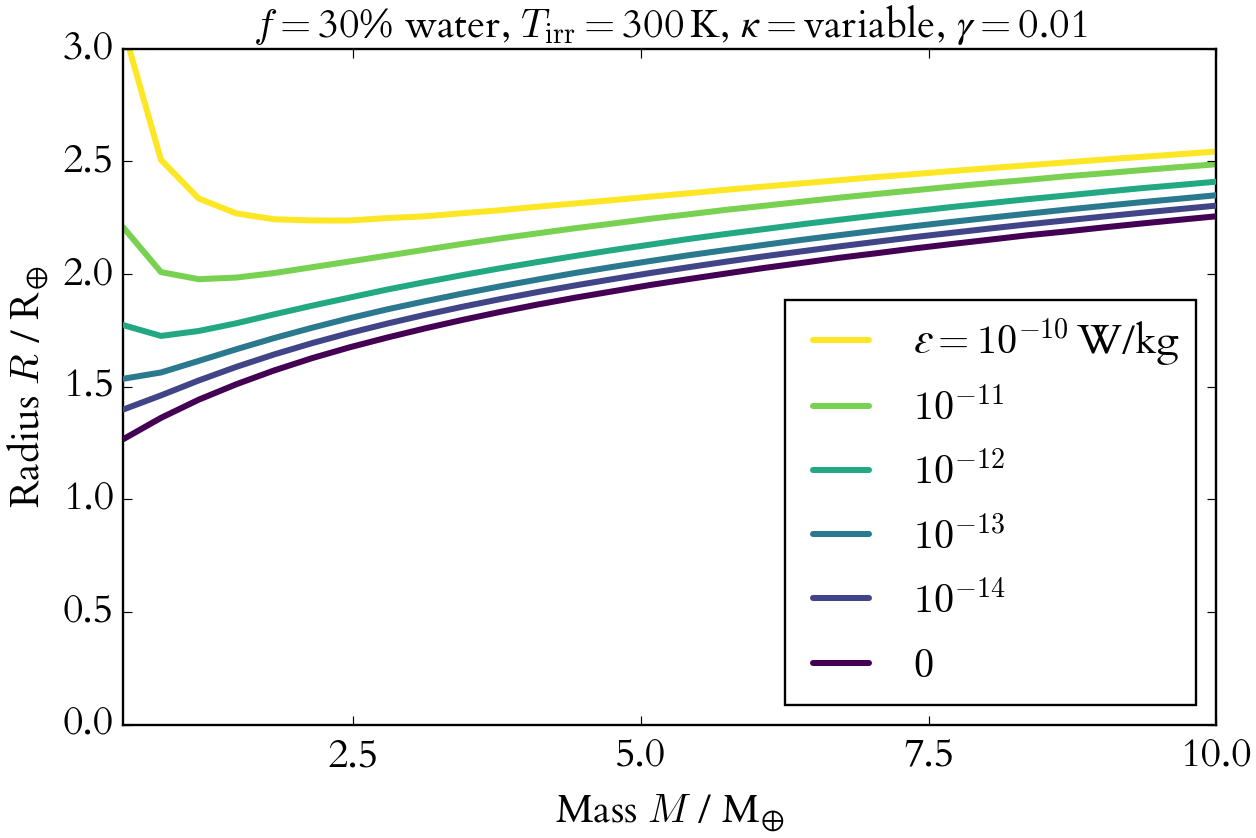

In [130]:
autofig("internal-heat", Normal) do
    d = loadfigdata("internal-heat")
    colors = seqcolors(:viridis, length(d["ɛs"])) |> reverse
    
    let ɛs = d["ɛs"], Ms = d["Ms"], Rs = d["Rs"]
        labels = latex_power.(ɛs')
        addunit!(labels, "W/kg")
        addsym!(labels, "ɛ")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $κ=$κ0, $γ=$γ0", d)
        
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end


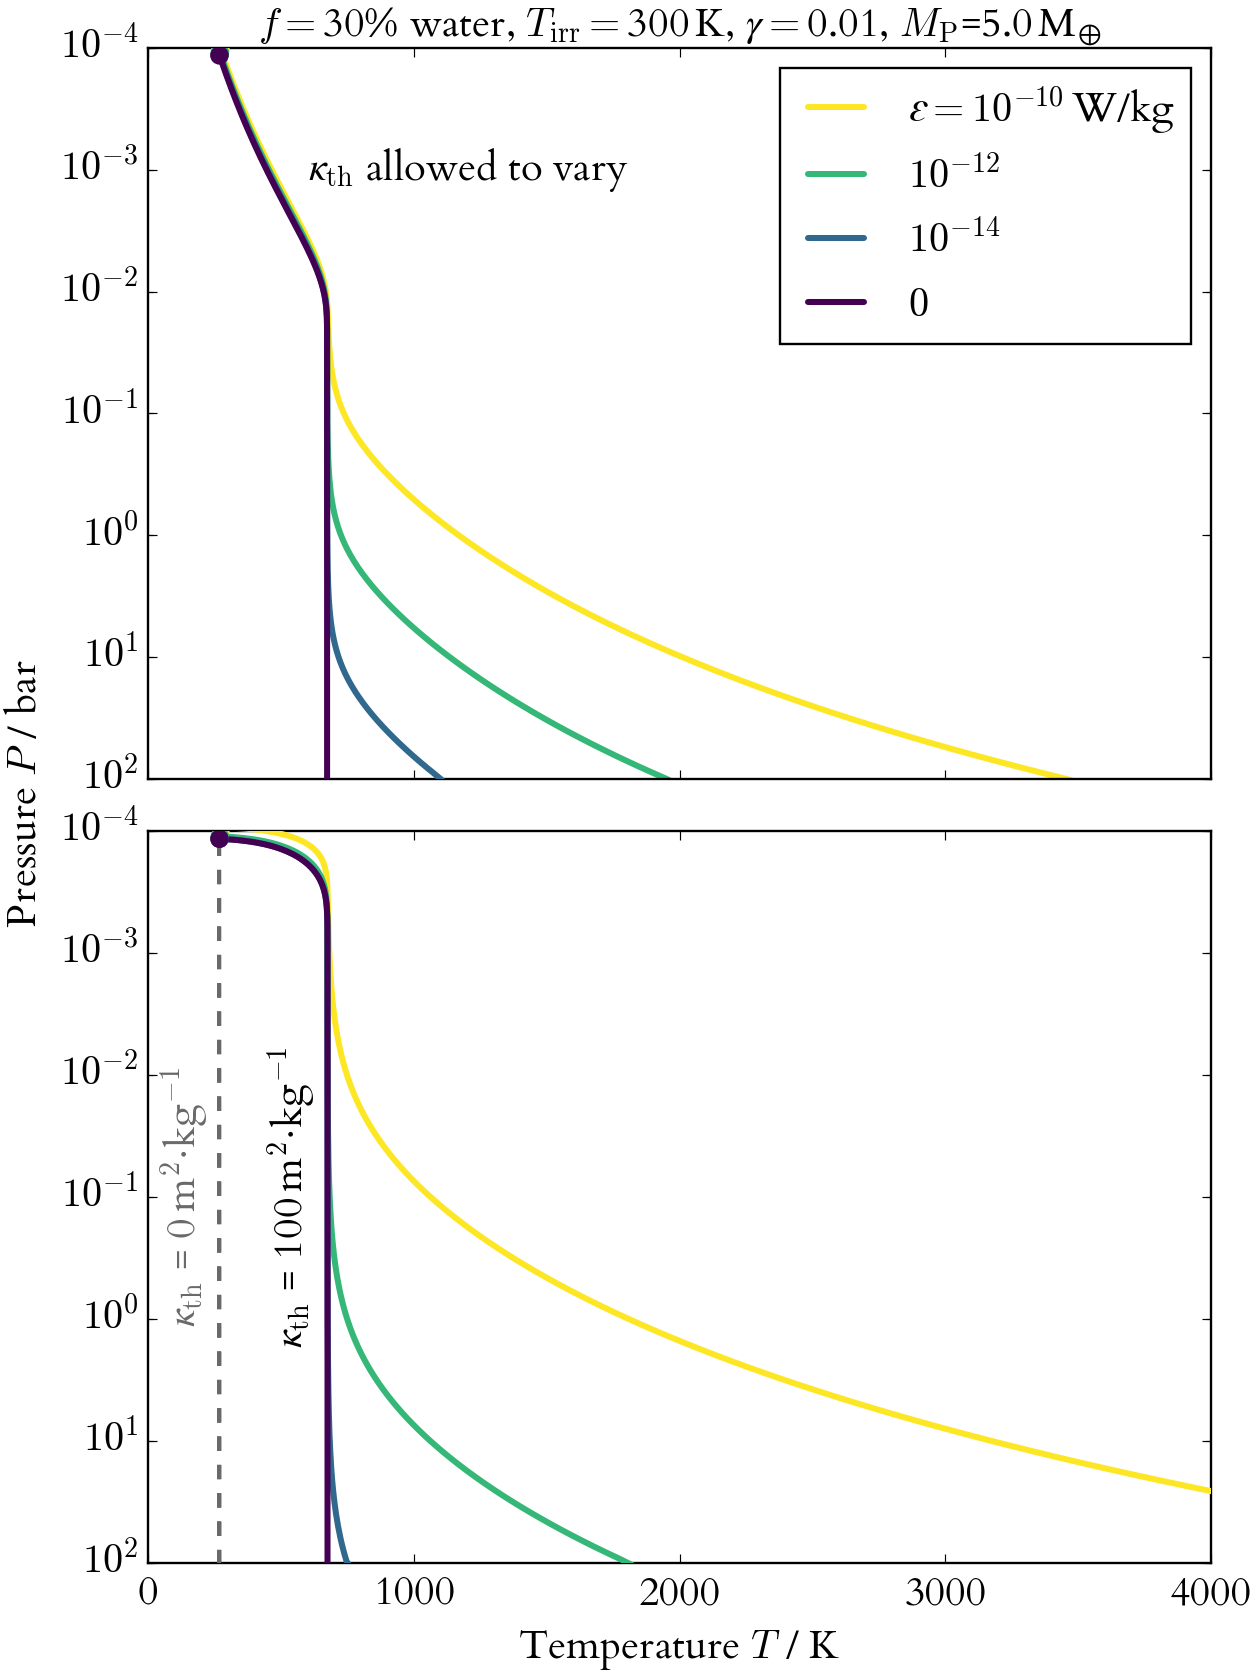

In [177]:
autofig("internal-heat-profiles", Normal, vscale=2) do
    d_all = loadfigdata("internal-heat-profiles")
    dn = d_all["nothing"]
    d0 = d_all["0"]
    d100 = d_all["100"]
    
    blankfmt = x -> ""
    xlims = (0, 4000)
    ylabel = L"Pressure $P$ / bar"
    ylabel_spaced = repeat(" ", 75) * ylabel
    
    colors = seqcolors(:viridis, length(dn["ɛs"])) |> reverse
    
    top = plot()
    bottom = plot()
    
    let ɛs = dn["ɛs"], Ps = dn["Ps"], Ts = dn["Ts"]
        labels = latex_power.(ɛs')
        addunit!(labels, "W/kg")
        addsym!(labels, "ɛ")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $γ=$γ0, $M_\mathrm{P}$=M0", dn)
        
        plot!(top, Ts/K, Ps/bar,
            title=title, labels=labels, palette=colors,
            xaxis=(xlims, blankfmt), 
            yaxis=(:log10, :flip, (1e-4, 1e2)))
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(top, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
        
        annotate_color!(600, 1e-3, L"$κ_\mathrm{th}$ allowed to vary", :black)
    end
    
    let Ps = d0["Ps"], Ts = d0["Ts"]
        plot!(bottom, Ts/K, Ps/bar, s=:dash, label="", c=:dimgrey, lw=1,
            xaxis=(xlims, L"Temperature $T$ / K"),
            yaxis=(:log10, :flip, (1e-4, 1e2)))
        annotate_color!(440, 1e-1, L"$κ_\mathrm{th}$ = 100$\,$m$^2⋅$kg$^{-1}$", :black, rotation=90)
    end 
    
    let Ps = d100["Ps"], Ts=d100["Ts"]
        plot!(bottom, Ts/K, Ps/bar, label="", palette=colors)
        annotate_color!(40, 1e-1, L"$κ_\mathrm{th}$ = 0$\,$m$^2⋅$kg$^{-1}$", :dimgrey, rotation=90)
        ylabel!(bottom, ylabel_spaced)
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(bottom, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
    end
    
    plot(top, bottom, layout=grid(2,1))
end

#### Irradiation


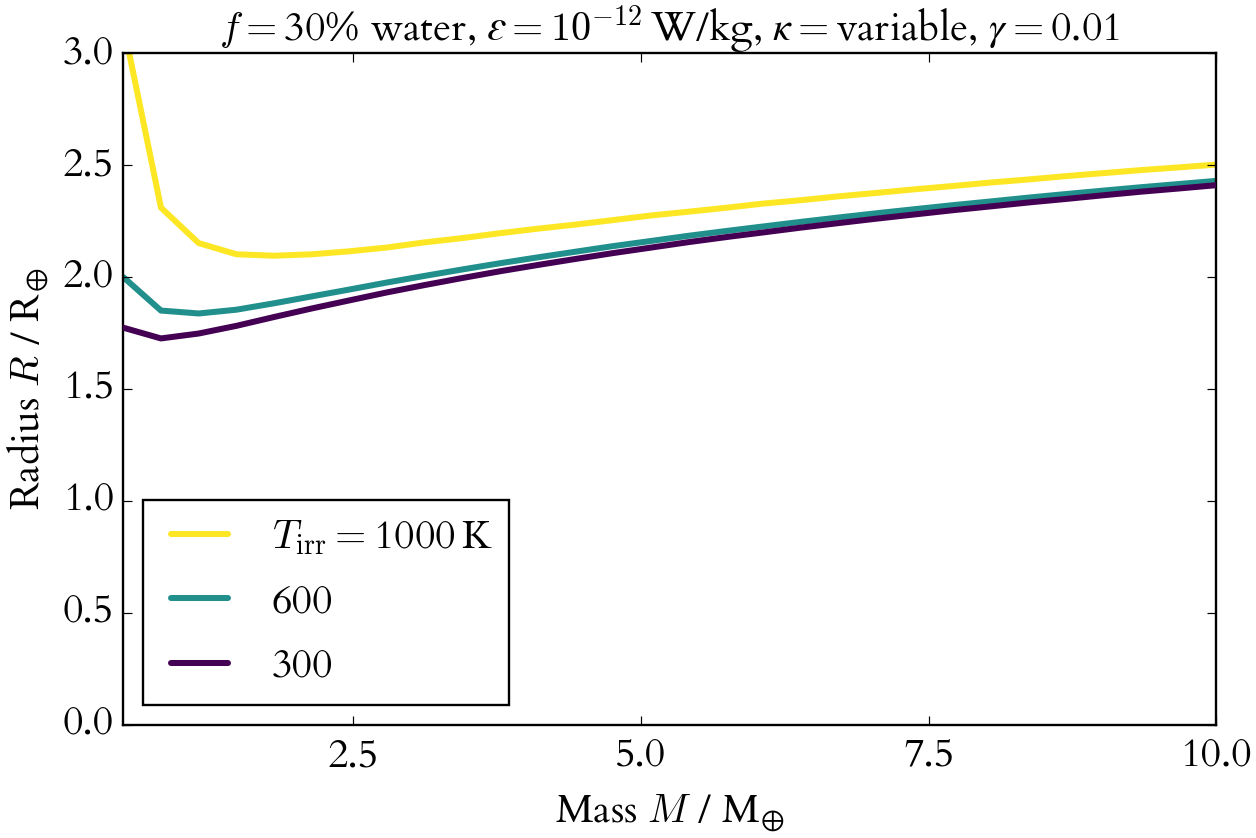

In [132]:
autofig("irradiation", Normal) do
    d = loadfigdata("irradiation")
    colors = seqcolors(:viridis, length(d["Tirrs"])) |> reverse
    
    let Tirrs = d["Tirrs"], Ms = d["Ms"], Rs = d["Rs"]
        labels = string.(Tirrs')
        addunit!(labels, "K")
        addsym!(labels, "T_\\mathrm{irr}")
        title = parvalues(L"$f=$f0, $ɛ=$ɛ0, $κ=$κ0, $γ=$γ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end


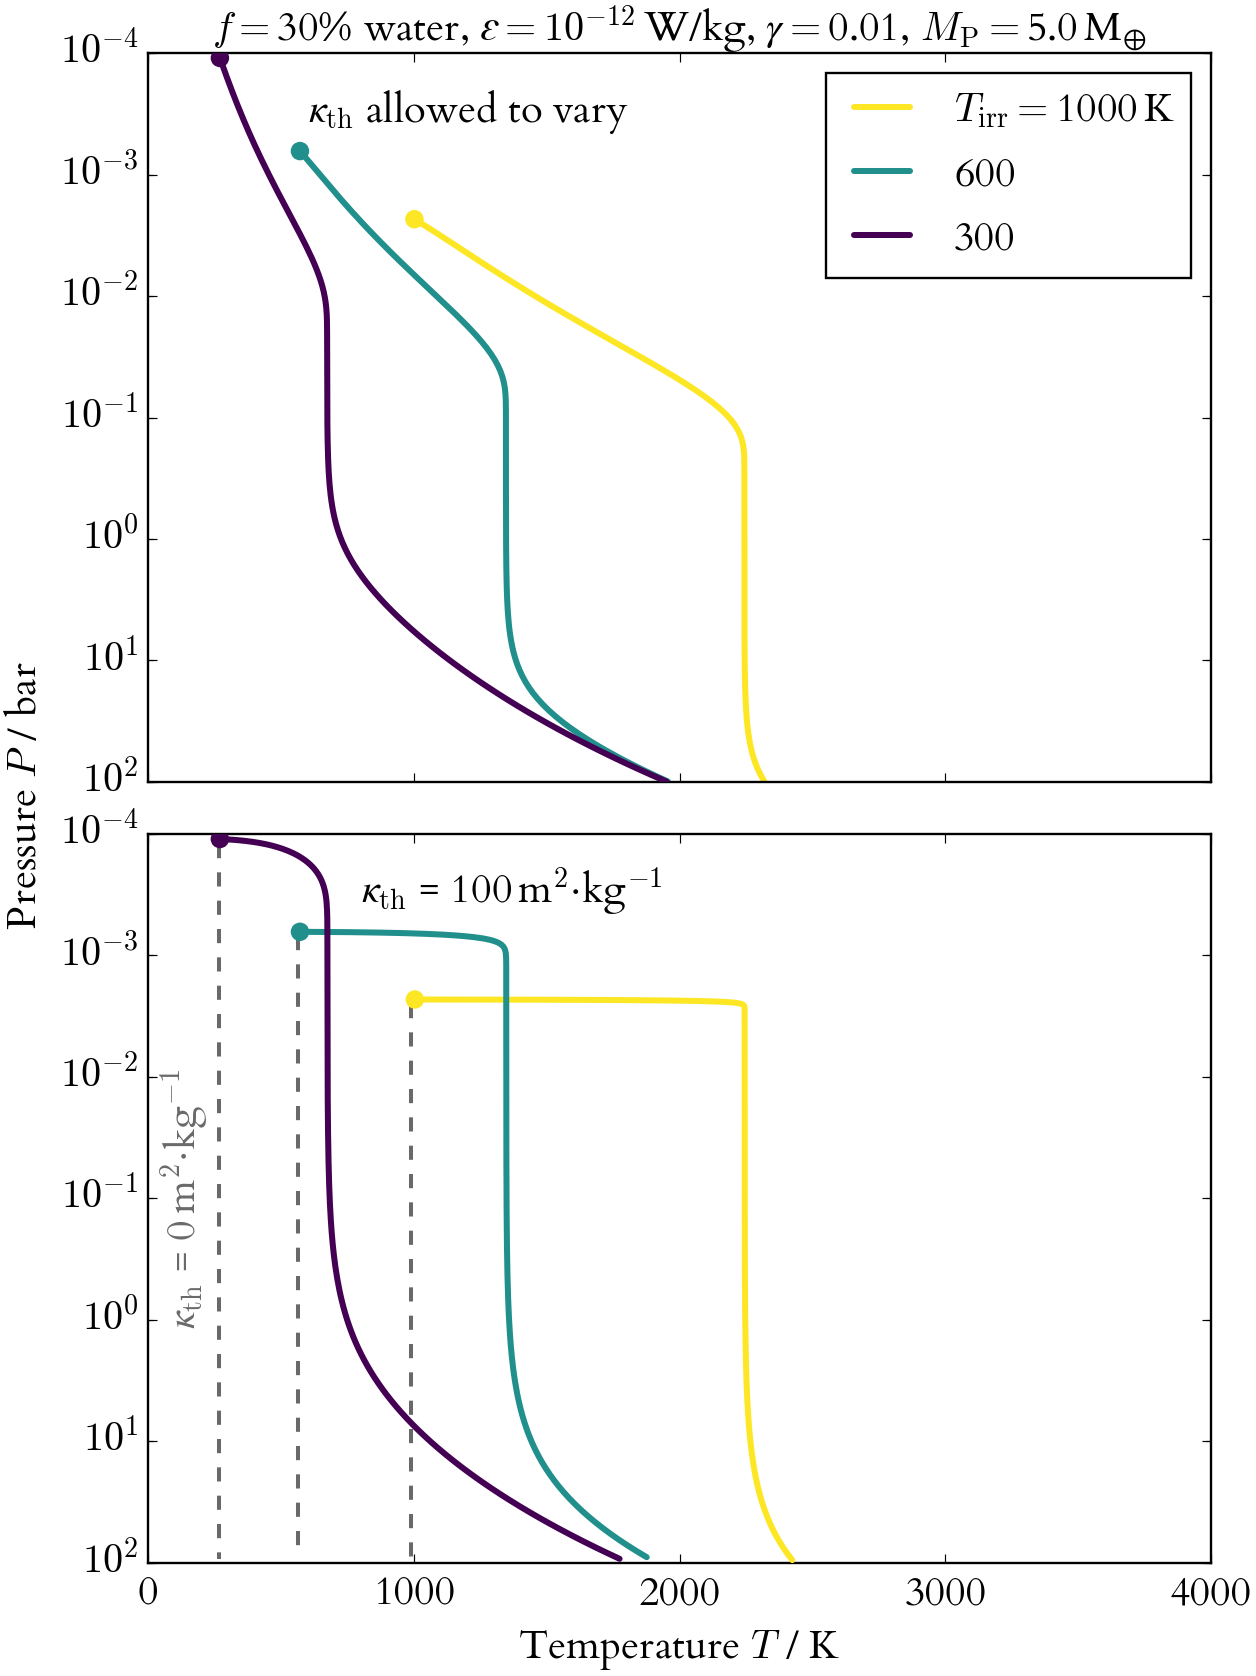

In [179]:
autofig("irradiation-profiles", Normal, vscale=2) do
    d_all = loadfigdata("irradiation-profiles")
    dn = d_all["nothing"]
    d0 = d_all["0"]
    d100 = d_all["100"]
    
    blankfmt = x -> ""
    xlims = (0, 4000)
    ylabel = L"Pressure $P$ / bar"
    ylabel_spaced = repeat(" ", 75) * ylabel
    
    colors = seqcolors(:viridis, length(dn["Tirrs"])) |> reverse
    
    top = plot()
    bottom = plot()
    
    let Tirrs = dn["Tirrs"], Ps = dn["Ps"], Ts = dn["Ts"]
        labels = string.(Tirrs')
        addunit!(labels, "K")
        addsym!(labels, "T_\\mathrm{irr}")
        title = parvalues(L"$f=$f0, $ɛ=$ɛ0, $γ=$γ0, $M_\mathrm{P}=$M0", dn)

        plot!(top, Ts/K, Ps/bar,
            title=title, labels=labels, palette=colors,
            xaxis=(xlims, blankfmt), 
            yaxis=(:log10, :flip, (1e-4, 1e2)))
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(top, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
        
        annotate_color!(600, 3e-4, L"$κ_\mathrm{th}$ allowed to vary", :black)
    end
    
    let Ps = d0["Ps"], Ts = d0["Ts"]
        plot!(bottom, Ts/K, Ps/bar, s=:dash, label="", c=:dimgrey, lw=1,
            xaxis=(xlims, L"Temperature $T$ / K"),
            yaxis=(:log10, :flip, (1e-4, 1e2)))
        annotate_color!(800, 3e-4, L"$κ_\mathrm{th}$ = 100$\,$m$^2⋅$kg$^{-1}$", :black)
    end 
    
    let Ps = d100["Ps"], Ts=d100["Ts"]
        plot!(bottom, Ts/K, Ps/bar, label="", palette=colors)
        annotate_color!(40, 1e-1, L"$κ_\mathrm{th}$ = 0$\,$m$^2⋅$kg$^{-1}$", :dimgrey, rotation=90)
        ylabel!(bottom, ylabel_spaced)
        Tphots = [T[1] for T in Ts]
        Pphots = [P[1] for P in Ps]
        scatter!(bottom, Tphots/K, Pphots/bar, label="", c=colors, markerstrokewidth=0, markersize=6)
    end
    
    plot(top, bottom, layout=grid(2,1))
end

### Core fraction


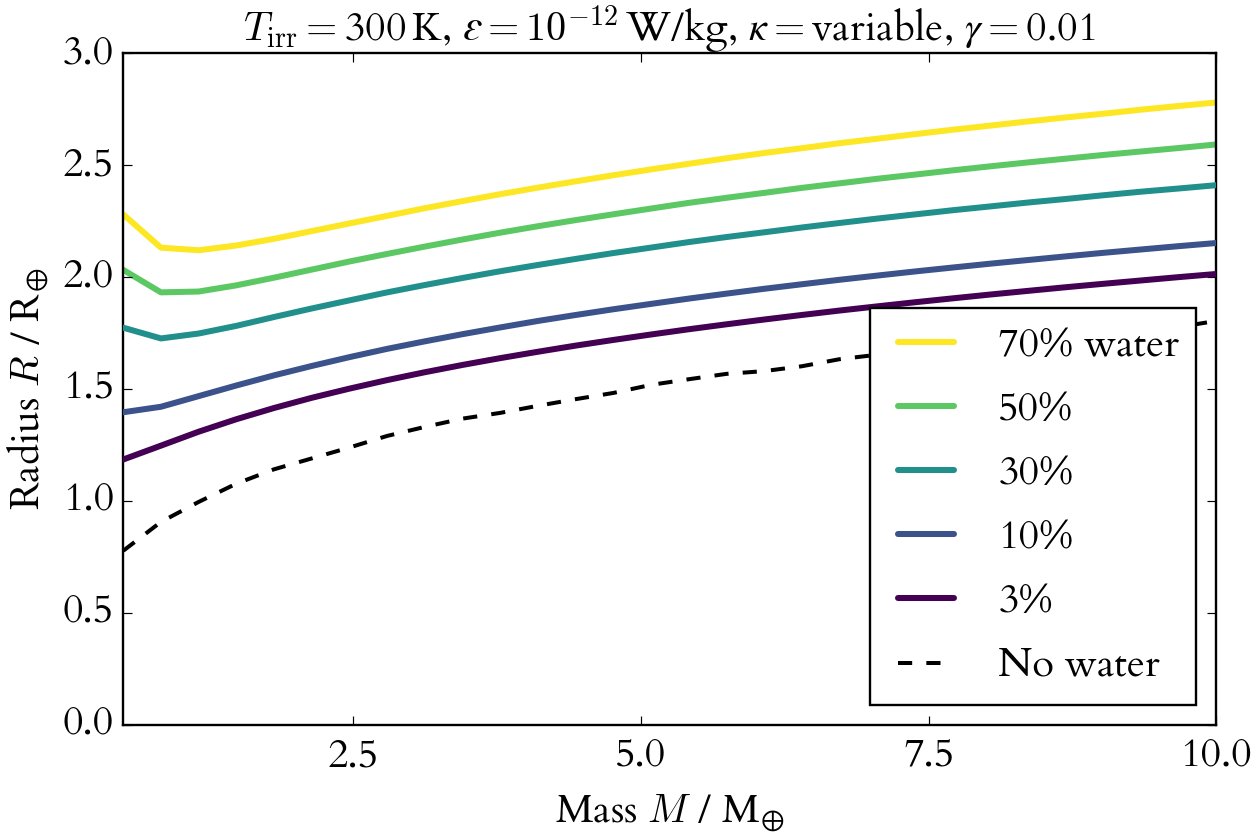

In [134]:
autofig("core-fraction", Normal) do
    d = loadfigdata("core-fraction")
    colors = seqcolors(:viridis, length(d["fs"])) |> reverse
    
    let fs = d["fs"], Ms = d["Ms"], Rs = d["Rs"], Rs_rock = d["Rs_rock"]
        wfrac_percent = map(f -> 100 - trunc(Int, 100f), fs)
        labels = map(wf -> "$wf%", wfrac_percent')
        labels[1] *= " water"
        title = parvalues(L"$T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $κ=$κ0, $γ=$γ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
        plot!(Ms/M_earth, Rs_rock/R_earth, linewidth=1, linestyle=:dash, color=:black, label="No water")
    end
end

### Atmospheric treatments

#### Opacity


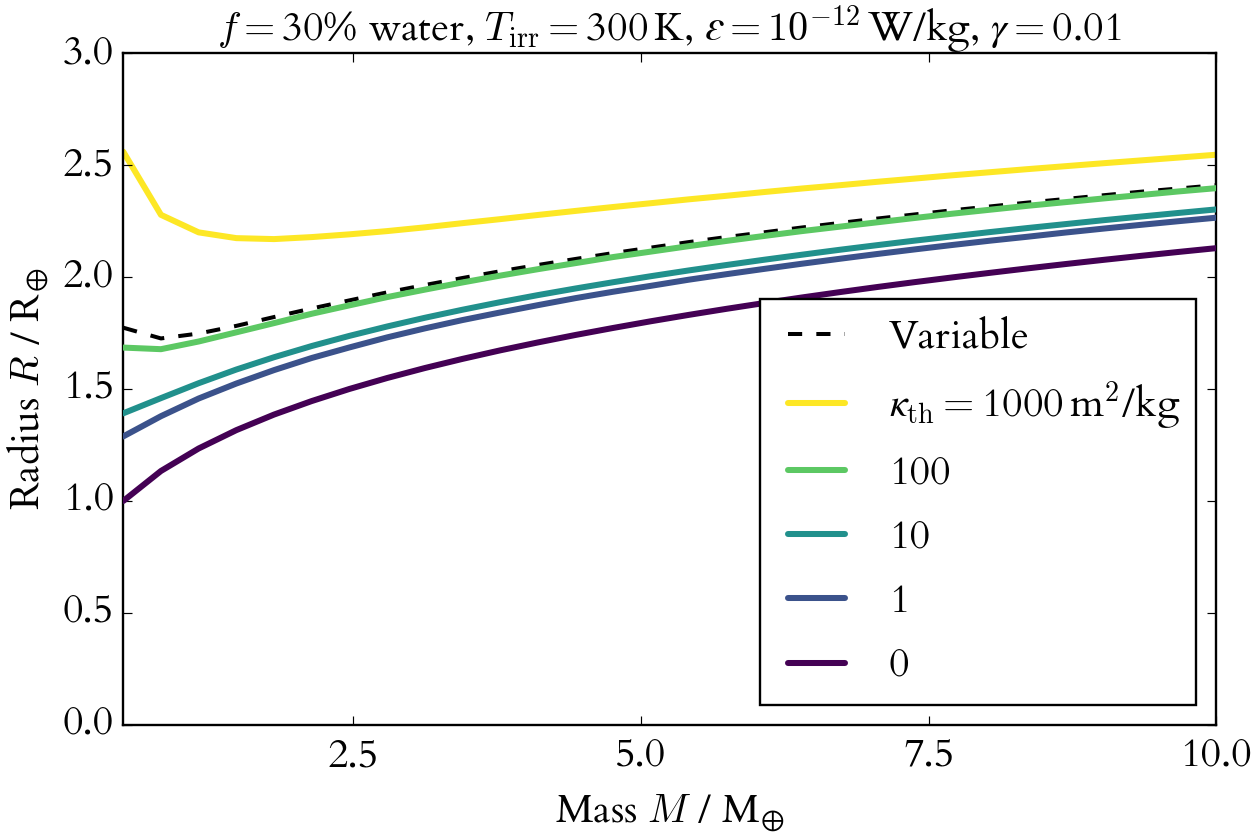

In [142]:
autofig("opacities", Normal) do
    d = loadfigdata("opacities")
    colors = seqcolors(:viridis, 5) |> reverse
    permute!(colors, [5,1,2,3,4])
     
    let κs = d["κs"], Ms = d["Ms"], Rs = d["Rs"], Rs_freeκ = d["Rs_freeκ"]
        labels = map(κ -> "$κ", κs')
        addunit!(labels, "m\$^2\$/kg")
        addsym!(labels, "κ_\\mathrm{th}")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $γ=$γ0", d)
        plot(Ms/M_earth, Rs_freeκ/R_earth, linestyle=:dash, 
        color=:black, label="Variable", linewidth=1)
        plot!(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end

#### Opacity ratio


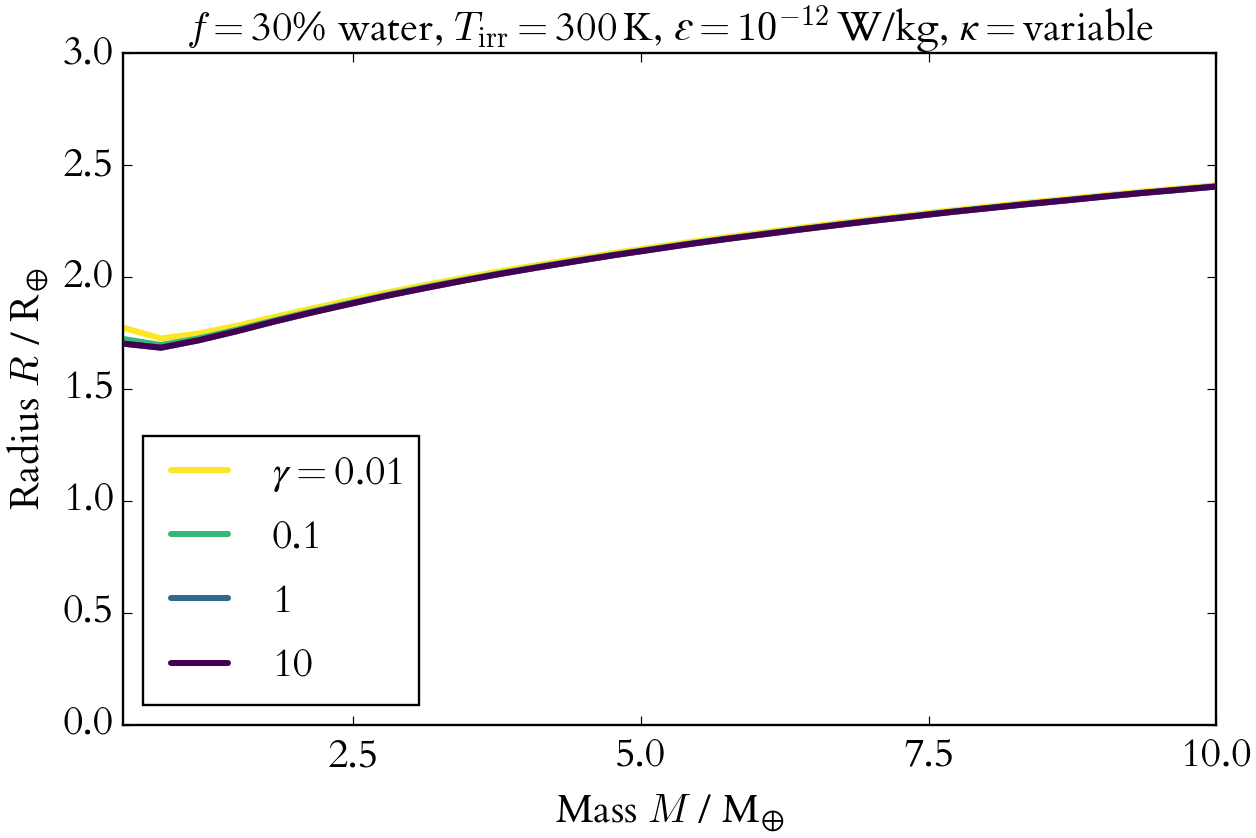

In [143]:
autofig("opacity-ratio", Normal) do
    d = loadfigdata("opacity-ratios")
    colors = seqcolors(:viridis, 4) |> reverse
    
    let γs = d["γs"], Ms = d["Ms"], Rs = d["Rs"]
        labels = map(γ -> "$γ", γs')
        addsym!(labels, "γ")
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $κ=$κ0", d)
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end

#### Transition pressure


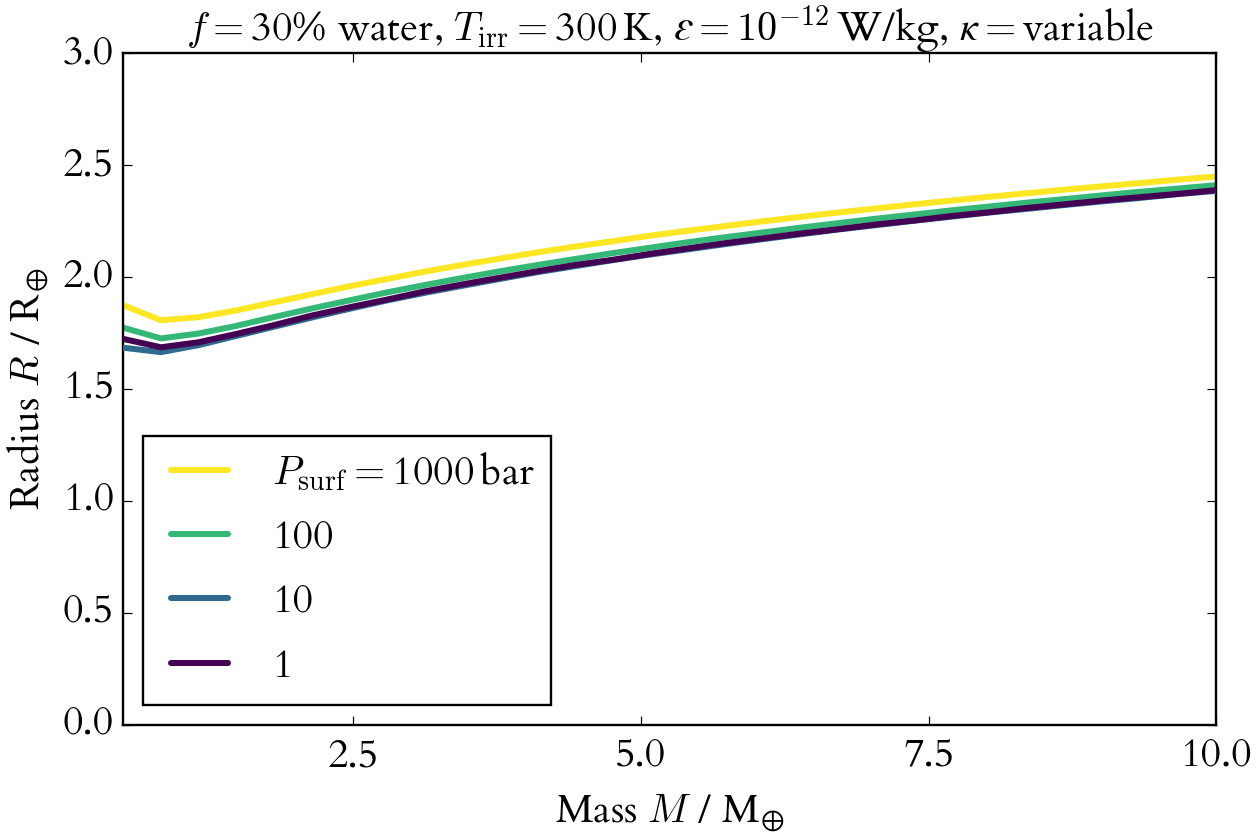

In [146]:
autofig("transition-pressure", Normal) do
    d = loadfigdata("transition-pressure")
    colors = seqcolors(:viridis, 4) |> reverse
    
    let Ps = d["Ps"], Ms = d["Ms"], Rs = d["Rs"]
        title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr0, $ɛ=$ɛ0, $κ=$κ0", d)
        labels = map(P -> "$(round(Int, P/bar))", Ps')
        addunit!(labels, "bar")
        addsym!(labels, "P_\\mathrm{surf}")
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, title=title, palette=colors)
    end
end

### Atmospheric thickness comparisons

#### Externally-heated & scale height


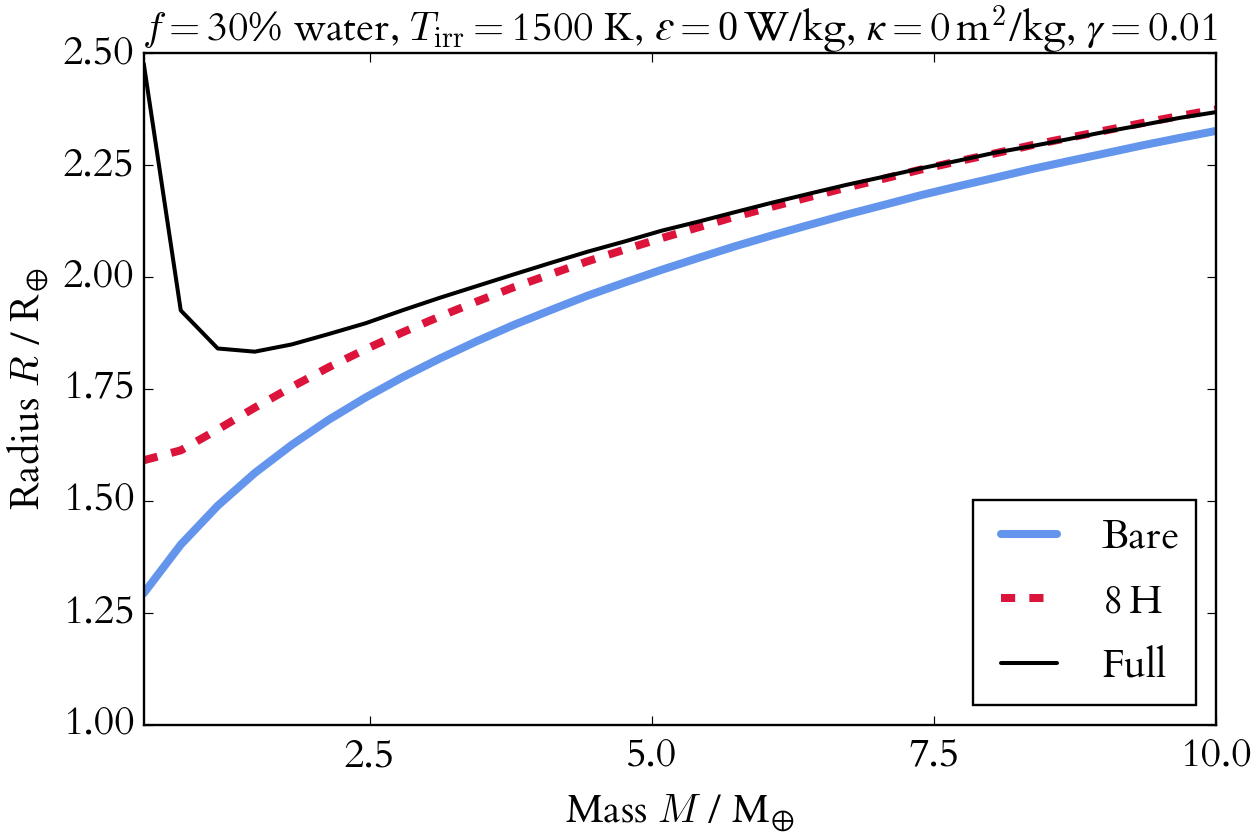

In [149]:
autofig("atmospheric-thickness", Normal) do
    d = loadfigdata("atmospheric-thickness")
    Tirrs = d["Tirrs"]
    Tsurfs = d["Tsurfs"]
    Nscale = d["Nscale"]
    
    foreach(Tirrs) do Tirr
        Tirr == 1500 || return
        let Ms = d["Ms"], Rs_bare = d["Rs_bare"][Tirr], Rs = d["Rs"][Tirr],
            Hs = d["Hs"][Tirr], Tsurf = Tsurfs[Tirr]
            
            title = parvalues(L"$f=$f0, $T_\mathrm{irr}=$Tirr, $ɛ=$ɛ0, $κ=$κ0, $γ=$γ0", d)
            title = replace(title, "Tirr", string(Tirr) * " K")
            
            labels = ["Bare" (string(Nscale)*L"$\,$H") "Full"]
            linewidths = [2 2 1]
            linestyles = [:solid :dash :solid]
            linecolors = [:cornflowerblue :crimson :black]
            Rs_combined = hcat(Rs_bare, Rs_bare + Nscale*Hs, Rs)
            p = plot(Ms/M_earth, Rs_combined/R_earth, xaxis=xaxis, yaxis=yaxis, 
            label=labels, linewidth=linewidths, linestyle=linestyles, title=title,
            linecolor=linecolors)
            ylims!(1.0, 2.5)
            display(p)
        end
    end
end

#### Internal-external comparison


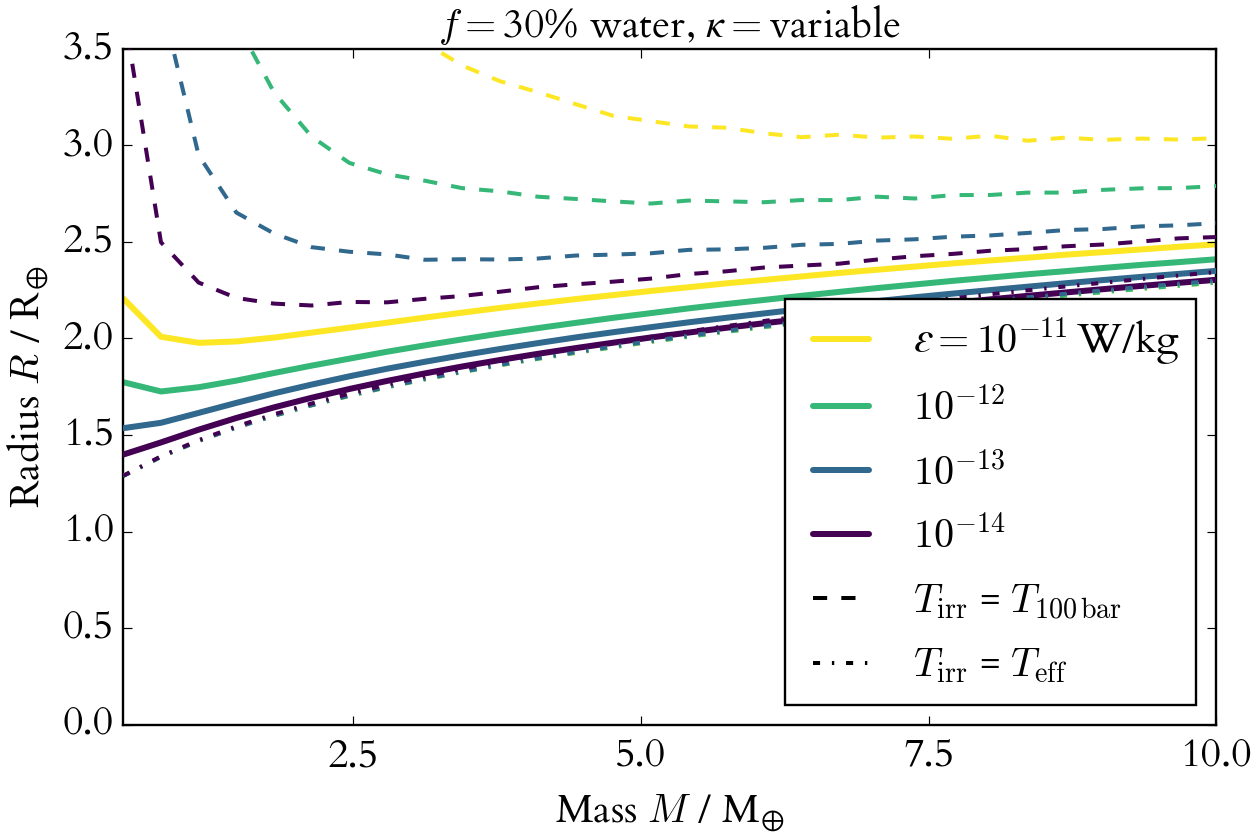

In [173]:
autofig("internal-vs-external", Normal) do
    d = loadfigdata("internal-vs-external")
    
    let Ms = d["Ms"], Rs_i = d["Rs_internal"], ɛs = d["ɛs"],
        Rs_e1 = d["Rs_external_100bar"], Rs_e2 = d["Rs_external_eq"]
        
        title = parvalues(L"$f=$f0, $κ=$κ0", d)
        labels = latex_power.(ɛs')
        addunit!(labels, "W/kg")
        addsym!(labels, "ɛ")
        colors = [:cornflowerblue :coral :limegreen :darkviolet]
        colors = seqcolors(:viridis, 4) |> reverse
        colors = reshape(colors, (1, 4))
        
        p = plot(Ms/M_earth, Rs_i/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, 
        title=title, linecolor=colors)
        plot!(Ms/M_earth, Rs_e1/R_earth, linestyle=:dash, linewidth=1, label="",
        linecolor=colors)
        plot!(Ms/M_earth, Rs_e2/R_earth, linestyle=:dashdot, linewidth=1, label="",
        linecolor=colors)
        plot!([-99, -99], linestyle=:dash, label=L"$T_\mathrm{irr}$ = $T_\mathrm{100\,bar}$", linecolor=:black, linewidth=1)
        plot!([-99, -99], linestyle=:dashdot, label=L"$T_\mathrm{irr}$ = $T_\mathrm{eff}$", linecolor=:black, linewidth=1)
        ylims!(0, 3.5)
        
        display(p)
    end
end

#### Grid size comparison


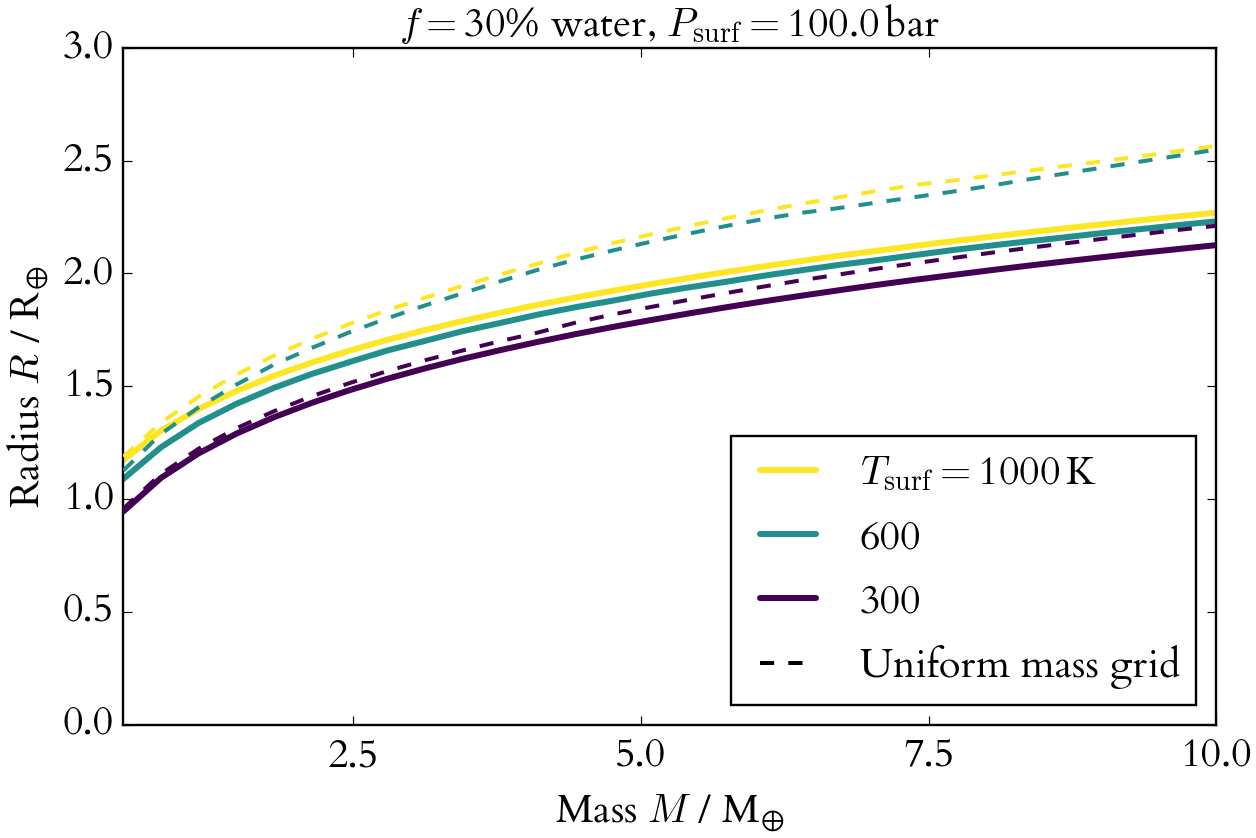

In [170]:
autofig("grid-error", Normal) do
    d = loadfigdata("grid-error")
    
    let Ms = d["Ms"], Rs = d["Rs"], Rs_bad = d["Rs_bad"], Tsurfs = d["Tsurfs"]
        title = parvalues(L"$f=$f0, $P_\mathrm{surf}=$Psurf0", d)
        labels = string.(Tsurfs')
        addunit!(labels, "K")
        addsym!(labels, "T_\\mathrm{surf}")
        colors = [:cornflowerblue :coral :limegreen :darkviolet]
        colors = seqcolors(:viridis, 3) |> reverse
        colors = reshape(colors, (1,3))

        
        plot(Ms/M_earth, Rs/R_earth, label=labels, xaxis=xaxis, yaxis=yaxis, 
        title=title, linecolor=colors)
        plot!(Ms/M_earth, Rs_bad/R_earth, linestyle=:dash, label="", 
        linecolor=:black, linewidth=1, linecolor=colors)
        plot!([-99, -99], linestyle=:dash, label="Uniform mass grid", linecolor=:black, linewidth=1)
    end
end